# Dogs VS Cats

This was originally a challenge in building a classifier aimed at the world's best Machine Learning and AI Practitioners but the technology has advanced so quickly, you'll see how you can do it in just a few minutes with some simple Convolutional Neural Network programming.

Also, you may notice some warnings about missing or corrupt EXIF data as the images are being loaded into the model for training. Don't worry about this -- it won't impact your model! :)

[Dogs VS Cats dataset from Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)

We will be using the following packages:
* **Pandas** - To format the data.
* **Scikit-learn** - To pre-process the data for training and validation.
* **TensorFlow 2** - To build, train and evaluate the Convolutional Neural Network.
* **Matplotlib** - To visualize the accuracy and loss during training and validation.

#### NOTE: This is not a submission for the Kaggle competition but a detailed analysis on how to classify this dataset

# Import the packages

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
filenames = os.listdir("./dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


### Split data into training and validation

In [3]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

### Training Data Augmentation and Generator

In [4]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20,
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20,
)


Found 5000 validated image filenames belonging to 2 classes.


## Convolutional Neural Network

### Due to the large dataset we will be applying Transfer Learning via a pre-trained model known as InceptionV3

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [7]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


### Train and Evaluate the model

In [8]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 21s - loss: 0.3879 - accuracy: 0.8530 - val_loss: 0.0993 - val_accuracy: 0.9560
Epoch 2/20
100/100 - 20s - loss: 0.2203 - accuracy: 0.9080 - val_loss: 0.1027 - val_accuracy: 0.9610
Epoch 3/20
100/100 - 23s - loss: 0.2414 - accuracy: 0.9055 - val_loss: 0.1641 - val_accuracy: 0.9470
Epoch 4/20
100/100 - 23s - loss: 0.2256 - accuracy: 0.9175 - val_loss: 0.1473 - val_accuracy: 0.9410
Epoch 5/20
100/100 - 22s - loss: 0.2187 - accuracy: 0.9195 - val_loss: 0.1146 - val_accuracy: 0.9650
Epoch 6/20
100/100 - 27s - loss: 0.1990 - accuracy: 0.9270 - val_loss: 0.1449 - val_accuracy: 0.9530
Epoch 7/20
100/100 - 26s - loss: 0.2204 - accuracy: 0.9120 - val_loss: 0.1068 - val_accuracy: 0.9590
Epoch 8/20
100/100 - 25s - loss: 0.1886 - accuracy: 0.9350 - val_loss: 0.1556 - val_accuracy: 0.9480
Epoch 9/20
100/100 - 26s - loss: 0.1922 - accuracy: 0.9295 - val_loss: 0.1135 - val_accuracy: 0.9620
Epoch 10/20
100/100 - 27s - loss: 0.1903 - accuracy: 0.9310 - val_loss: 0.1287 - val_accura

### Visualize the Accuracy and Loss

<Figure size 432x288 with 0 Axes>

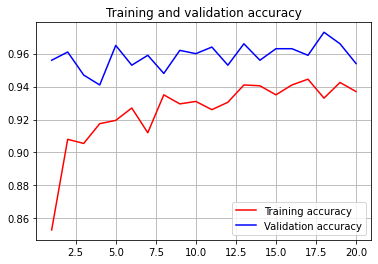

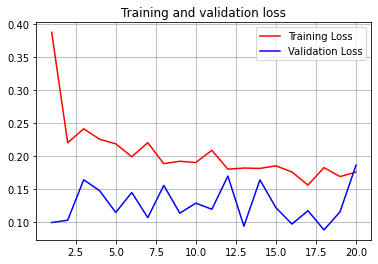

<Figure size 432x288 with 0 Axes>

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, EPOCHS+1)

# Accuracy Graph
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.figure()

# Loss Graph
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.figure()